<a href="https://colab.research.google.com/github/ismailakbas/AIDER/blob/main/PyTorchAIDER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

from google.colab import drive
drive.mount("/content/drive")

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import cv2
from google.colab.patches import cv2_imshow

Mounted at /content/drive


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Veri setini yükleme
dataset = ImageFolder(root = "drive/MyDrive/Evşen/AIDER", transform = data_transforms)

In [ ]:
# Veri setini eğitim ve test olarak bölme

train_size = int(0.8 * len(dataset))  # %80 eğitim, %20 test
test_size = len(dataset) - train_size

#cross validation five hold


#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [800, 200])
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size]) #train_dataset ve test_dataset i 2 vektöre ayır -> random_split yerine train_test_split (sklearn)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

#ResNet-50 34 101
#VGG16 19

In [ ]:
print(train_dataset)

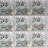

In [ ]:

random_image = train_dataset[10][0].numpy().reshape(224, 224, 3)
cv2_imshow(random_image, cmap = "gray")




In [ ]:
print(random_image)

[[[0.5686275  0.5647059  0.5529412 ]
  [0.53333336 0.5254902  0.52156866]
  [0.52156866 0.5372549  0.5568628 ]
  ...
  [0.5764706  0.58431375 0.59607846]
  [0.6156863  0.63529414 0.654902  ]
  [0.6784314  0.67058825 0.64705884]]

 [[0.5882353  0.5803922  0.5686275 ]
  [0.56078434 0.5568628  0.5568628 ]
  [0.5529412  0.5529412  0.5529412 ]
  ...
  [0.6156863  0.62352943 0.63529414]
  [0.6431373  0.6509804  0.654902  ]
  [0.65882355 0.64705884 0.63529414]]

 [[0.59607846 0.5921569  0.5882353 ]
  [0.5882353  0.5882353  0.5921569 ]
  [0.6        0.60784316 0.6117647 ]
  ...
  [0.627451   0.62352943 0.61960787]
  [0.6156863  0.6117647  0.6039216 ]
  [0.59607846 0.6        0.59607846]]

 ...

 [[0.34117648 0.3372549  0.34901962]
  [0.4117647  0.40784314 0.4117647 ]
  [0.41568628 0.38431373 0.34509805]
  ...
  [0.81960785 0.92156863 0.89411765]
  [0.91764706 0.9137255  0.93333334]
  [0.9411765  0.94509804 0.9490196 ]]

 [[0.34901962 0.34509805 0.34509805]
  [0.27450982 0.23529412 0.21176471]


In [ ]:
print(train_dataset[10][1])

3


In [ ]:
class MyModel(nn.Module):

  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, stride=1, padding=2)
    self.batchnorm2 = nn.BatchNorm2d(256)
    self.maxpool2 = nn.MaxPool2d(2, 2)


    self.fc1 = nn.Linear(64 * 112 * 112, 256)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(256, len(dataset.classes))

  def forward(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.relu(x) #diğer relu lar -> parametric relu
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.maxpool2(x)
    x = x.view(-1, 64 * 112 * 112) #flatten fonk  x.shape

    x = self.fc1(x) # her işlemden sonra normalizasyon
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x) #softamx uygula
    return x

# Training 1

In [ ]:
for i, (inputs, labels) in enumerate(train_loader):
    CUDA = torch.cuda.is_available()
    print(labels)
    break

tensor([3, 2, 2, 0, 4, 3, 4, 3, 3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 3, 4, 3, 4, 1, 3,
        3, 0, 0, 3, 3, 3, 3, 1])


In [ ]:
model = MyModel()
CUDA = torch.cuda.is_available()

if CUDA:
  model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):

  correct = 0
  iterations = 0
  iter_loss = 0

  model.train()  # Eğitim moduna geç

  for i, (inputs, labels) in enumerate(train_loader):
    CUDA = torch.cuda.is_available()

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    iter_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  # Ağırlıkları güncelle

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    iterations += 1

  train_loss.append(iter_loss / iterations)
  train_accuracy.append(100 * correct / len(train_dataset))

  testing_loss = 0.0
  correct = 0
  iterations = 0

  model.eval()  # Değerlendirme moduna geç

  for i, (inputs, labels) in enumerate(test_loader):
    CUDA = torch.cuda.is_available()

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    testing_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()
    iterations += 1

  test_loss.append(testing_loss / iterations)
  test_accuracy.append(100 * correct / len(test_dataset))

  print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(
epoch + 1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))

KeyboardInterrupt: ignored

# Training 2

In [ ]:
model = MyModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}/{len(train_loader)}, Loss: {running_loss / 10}")
            running_loss = 0.0


correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

Epoch 1, Batch 10/162, Loss: 1.984720128774643


KeyboardInterrupt: ignored